# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



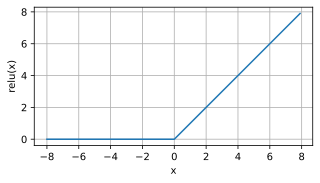

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

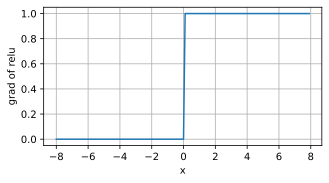

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

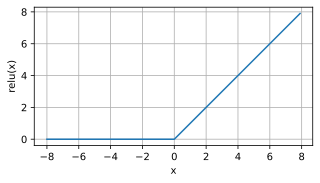

In [7]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

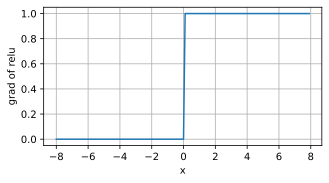

In [14]:
# Clear out previous gradients
# x.grad.data.zero_()
# 왜 초기화를 하면 오류가 뜨지...?

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

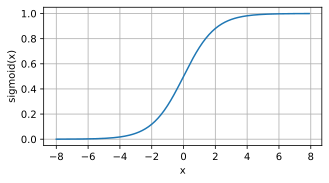

In [15]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

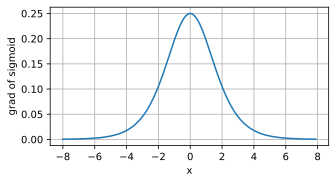

In [16]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

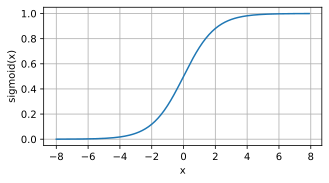

In [17]:
y = torch.sigmoid(x)

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

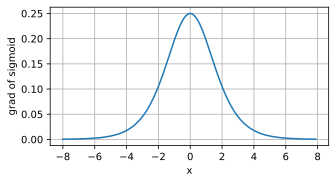

In [18]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [26]:
# 모듈 설치
!pip install scikit-learn


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB 5.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/11.0 MB 7.0 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/11.0 MB 7.8 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/11.0 MB 8.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/11.0 MB 7.4 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.0 MB 7.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.0 MB 7.8 MB/s eta 0:00:02
   ---------- ----------------------------- 2.8/11.0 MB 7.8 MB/s eta 0:00:02
   ----------- ---------------------------- 3.2/11.0 MB 7.8 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 7.5 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/11.0 MB 7.4 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.0 MB 7.1 MB/s eta 0:00:02
   ---

In [27]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [136]:
data = load_breast_cancer()

In [137]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [138]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [143]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [144]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


2

## Step 2 : CustomDataset 과 DataLoader

In [91]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [92]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [93]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [94]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [95]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [97]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


C:\Windows\Temp\ipykernel_4112\3819385690.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [98]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [99]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

## Step 5: Train Model

In [100]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Python Project\Practice\venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.7940959930419922
10 0.5715879797935486
20 0.48319166898727417
30 0.43179386854171753
40 0.4048069417476654
50 0.40345484018325806
60 0.40675270557403564
70 0.3839629590511322
80 0.3799823522567749
90 0.37303659319877625


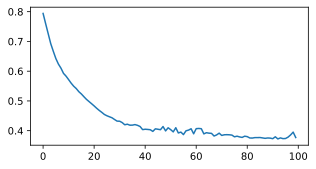

In [101]:
plt.plot(losses)
plt.show()

In [102]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [103]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00769474 0.9923052 ]
argmax를 한 후의 output은 1
accuracy는 0.9122807017543859


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [194]:
from sklearn.datasets import load_wine

### Wine 데이터셋
Wine 데이터셋은 178개의 와인 샘플과 13개의 화학 성분 특징으로 구성되어 있습니다. 데이터셋은 세 가지 종류의 와인(클래스 0, 1, 2)으로 라벨링 되어 있습니다.


### Wine Dataset의 input : 13, output : 3
1차 시도 : 13 -> 398 -> 15 -> 10 -> 3 (기존 세팅)
1차 결과 : accuracy는 0.9259259259259259

2차 시도 : 13 -> 169 -> 27 -> 9 -> 3
2차 결과 : accuracy는 0.9629629629629629

3차 시도 : 13 -> 169 -> 81 -> 27 -> 9 -> 3 (layer 수를 늘리면 더 좋겠지..?)
3차 결과 : accuracy는 0.9074074074074074 (아니였네... overfitting된듯 ㅜㅜ)

4차 시도 : 3차 시도에서 activate function을 sigmoid->ReLU 변경
4차 결과 : accuracy는 0.9444444444444444 (증가하였으나, 여전히 그래프상 overfitting이 의심됨)

5차 시도 : ReLU 유지 / 13 -> 130 -> 81 -> 27 -> 9 -> 3 (과적합 문제를 해결하고자 perceptron수를 줄임)
5차 결과 : accuracy는 0.9814814814814815 

In [269]:
# Load dataset = wine으로 데이터 로드 
data = load_wine()

input = data.data
output = data.target

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(831)
if device == 'cuda' :
    torch.cuda.manual_seed_all(831)

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify = data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

x_len = len(x_train[0])
y_len = len(y_train.unique())


In [270]:
# Define Model
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(x_len ,130, bias=True), # input_layer = 13, hidden_layer1 = 130
            nn.ReLU(),
            nn.BatchNorm1d(130)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(130, 81, bias=True), # hidden_layer1 = 130, hidden_layer2 = 81
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(81, 27, bias=True), # hidden_layer2 = 81, hidden_layer3 = 27
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(27, 9, bias=True), # hidden_layer3 = 27, hidden_layer4 = 9
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Linear(9, y_len, bias=True), # hidden_layer4 = 9, output_layer = 3
            nn.Softmax()
        )

    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)
        return output

In [271]:
model = Model().to(device)
model.apply(init_weights)

C:\Windows\Temp\ipykernel_4112\147145950.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=130, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=130, out_features=81, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=81, out_features=27, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=27, out_features=9, bias=True)
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Linear(in_features=9, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [272]:
# Loss function and Optimizer
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [273]:
# Train Model
losses = []
for epoch in range(100):

    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

    if epoch % 10 == 0:
        print(epoch, cost.item())

C:\Python Project\Practice\venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.117834210395813
10 0.759921133518219
20 0.6270217895507812
30 0.5849936604499817
40 0.5817512273788452
50 0.5896216630935669
60 0.5882449150085449
70 0.5833256840705872
80 0.5979216694831848
90 0.5765536427497864


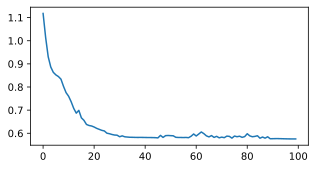

In [274]:
# Result(graph)
plt.plot(losses)
plt.show()

In [275]:
with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis =1)
    accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.0000000e+00 5.3720357e-09 9.8985185e-15]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815
